#### Install Required Packages

In [1]:
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler


#### Exploratary Data Analysis : UK Demand Data
Inspect UK demand data


In [2]:
import pandas as pd

df_demand = pd.read_csv('uk_demand_data.csv')

# Inspect data
display(df_demand.shape)
display(df_demand.head())
display(df_demand.dtypes)
display(df_demand.isnull().any())

(96, 11)

,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,demand
0,Q1 2001,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0
1,Q2 2001,78583.0,69547.0,43106.0,25028.0,19250.0,1327.0,0.0,0.0,10976.0,247817.0
2,Q3 2001,72592.0,35197.0,32242.0,15464.0,17828.0,844.0,0.0,0.0,9996.0,184163.0
3,Q4 2001,79324.0,120097.0,42442.0,34992.0,20964.0,2130.0,0.0,0.0,13706.0,313655.0
4,Q1 2002,82446.0,148988.0,52670.0,35837.0,20727.0,2287.0,0.0,0.0,13790.0,356745.0


date                       object
electricity_generation    float64
domestic                  float64
industrial                float64
services                  float64
producer_own_use          float64
operator_own_use          float64
lng_own_use               float64
storage_own_use           float64
others                    float64
demand                    float64
dtype: object

date                      False
electricity_generation    False
domestic                  False
industrial                False
services                  False
producer_own_use          False
operator_own_use          False
lng_own_use               False
storage_own_use           False
others                    False
demand                    False
dtype: bool

Timestamp Conversion

In [3]:
df_demand['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_demand['date']])
df_demand.head()

C:\Users\benja\AppData\Local\Temp\ipykernel_29860\3809532416.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_demand['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_demand['date']])


,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,demand
0,2001-01-01,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0
1,2001-04-01,78583.0,69547.0,43106.0,25028.0,19250.0,1327.0,0.0,0.0,10976.0,247817.0
2,2001-07-01,72592.0,35197.0,32242.0,15464.0,17828.0,844.0,0.0,0.0,9996.0,184163.0
3,2001-10-01,79324.0,120097.0,42442.0,34992.0,20964.0,2130.0,0.0,0.0,13706.0,313655.0
4,2002-01-01,82446.0,148988.0,52670.0,35837.0,20727.0,2287.0,0.0,0.0,13790.0,356745.0


Quarterly data is published on via multiple sectors

In [4]:
df_demand_final = pd.DataFrame()
df_demand_final['date'] = df_demand['date']
df_demand_final['domestic'] = df_demand['domestic'] 
df_demand_final['industrials'] = df_demand['industrial'] + df_demand['lng_own_use'] + df_demand['operator_own_use'] + df_demand['others'] + df_demand['producer_own_use'] + df_demand['storage_own_use'] +df_demand['services']
df_demand_final['elec'] = df_demand['electricity_generation']
df_demand_final['total'] = df_demand['demand']

display(df_demand_final.head())

,date,domestic,industrials,elec,total
0,2001-01-01,154586.0,137621.0,82019.0,374226.0
1,2001-04-01,69547.0,99687.0,78583.0,247817.0
2,2001-07-01,35197.0,76374.0,72592.0,184163.0
3,2001-10-01,120097.0,114234.0,79324.0,313655.0
4,2002-01-01,148988.0,125311.0,82446.0,356745.0


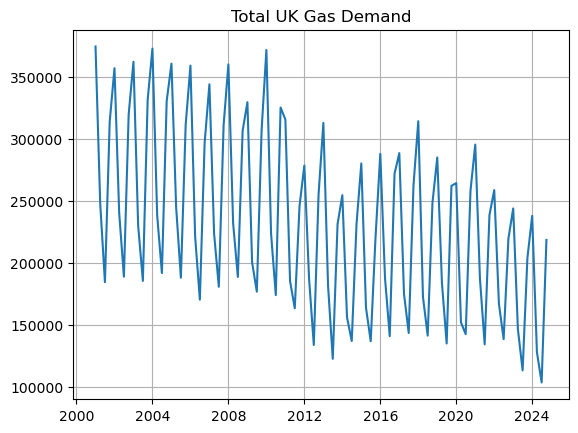

In [5]:
fig, ax = plt.subplots()
ax.plot(df_demand_final['date'], df_demand_final['total'])
ax.set_title('Total UK Gas Demand')
ax.grid(True)

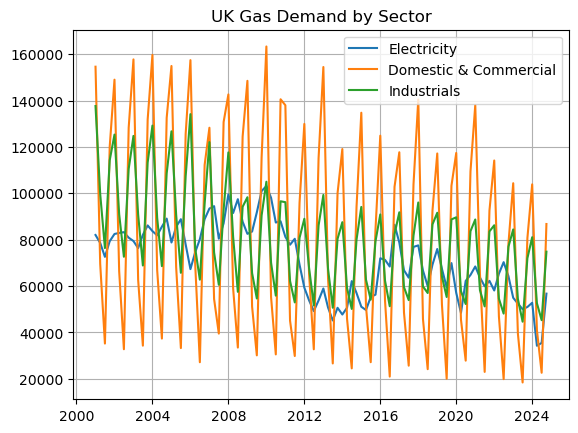

In [6]:
fig, ax = plt.subplots()
ax.plot(df_demand_final['date'], df_demand_final['elec'], label='Electricity')
ax.plot(df_demand_final['date'], df_demand_final['domestic'], label='Domestic & Commercial')
ax.plot(df_demand_final['date'], df_demand_final['industrials'], label='Industrials')
ax.set_title('UK Gas Demand by Sector')
ax.legend()
ax.grid(True)

#### External Regressor Data: EDA

In [7]:
df_weather = pd.read_csv('uk_weather_data.csv')
display(df_weather.shape)
display(df_weather.head())
display(df_weather.dtypes)
display(df_weather.isnull().any())

(96, 6)

,date,rainfall,sunhours,windspeed,temperature,heating_degree_days
0,Q1 2001,249.248935,2.832804,8.794621,4.714601,8.535148
1,Q2 2001,178.485001,6.452538,8.241631,11.421111,3.693704
2,Q3 2001,315.903293,5.462755,7.766157,15.850138,0.649218
3,Q4 2001,386.582732,2.790973,9.458103,8.534337,7.166271
4,Q1 2002,520.000982,2.735623,11.577786,6.979438,8.535148


date                    object
rainfall               float64
sunhours               float64
windspeed              float64
temperature            float64
heating_degree_days    float64
dtype: object

date                   False
rainfall               False
sunhours               False
windspeed              False
temperature            False
heating_degree_days    False
dtype: bool

In [8]:
df_weather['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_weather['date']])

C:\Users\benja\AppData\Local\Temp\ipykernel_29860\1204060040.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_weather['date']])


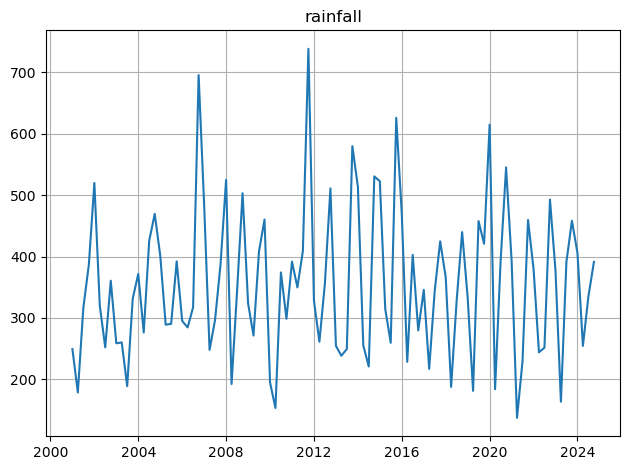

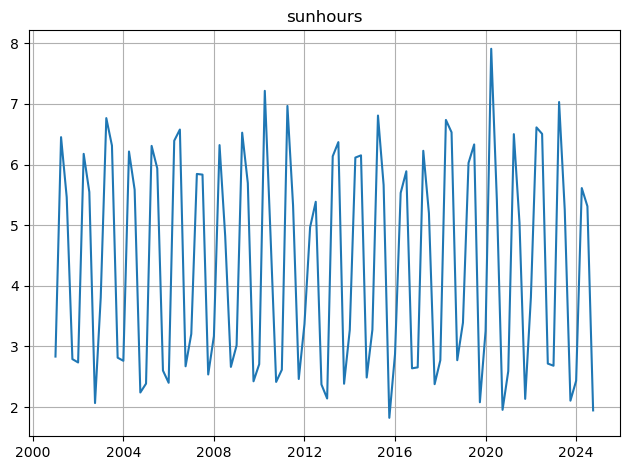

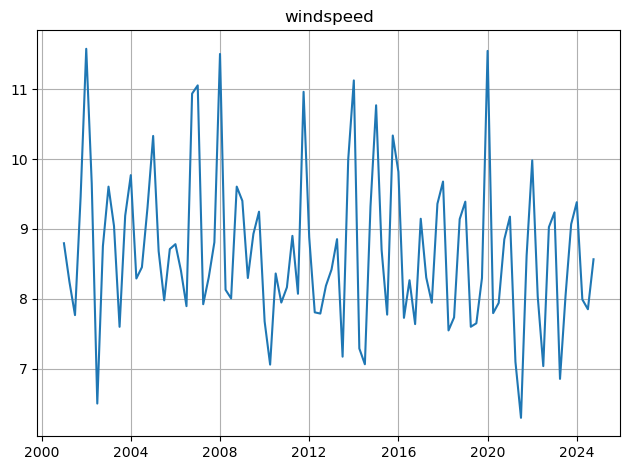

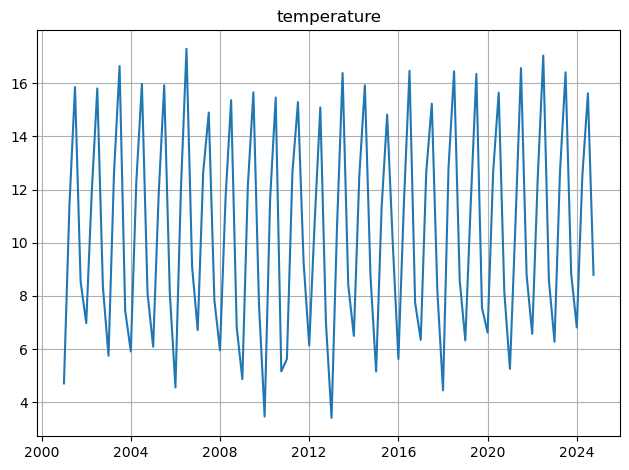

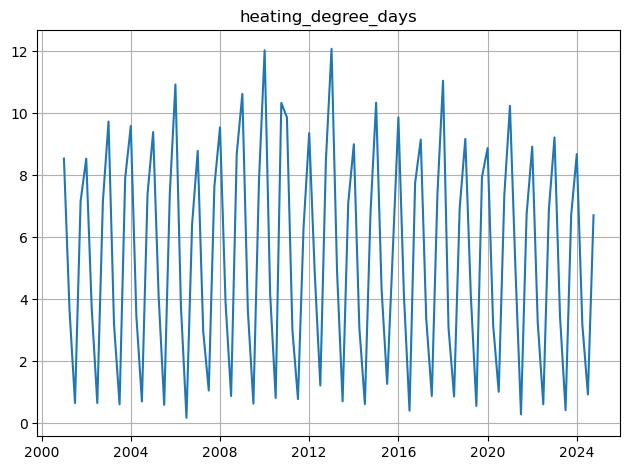

In [9]:
for i in df_weather.loc[:, df_weather.columns != 'date'].columns:
    plt.figure()
    plt.plot(df_weather['date'], df_weather[i])
    plt.title(i)
    plt.tight_layout()
    plt.grid(True)



#### UK Indices Data: EDA

In [10]:
df_indices = pd.read_csv('uk_indices_data.csv')
display(df_indices.shape)
display(df_indices.head())
display(df_indices.dtypes)
display(df_indices.isnull().any())

(96, 4)

,date,domestic_price,industrial_price,gdp
0,Q1 2001,50.659417,63.146926,457680
1,Q2 2001,52.133440,61.809519,459620
2,Q3 2001,52.296868,57.709785,462016
3,Q4 2001,52.465025,65.499853,463404
4,Q1 2002,54.150954,67.806783,464698


date                 object
domestic_price      float64
industrial_price    float64
gdp                   int64
dtype: object

date                False
domestic_price      False
industrial_price    False
gdp                 False
dtype: bool

In [11]:
df_indices['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_indices['date']])

C:\Users\benja\AppData\Local\Temp\ipykernel_29860\3361329138.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_indices['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_indices['date']])


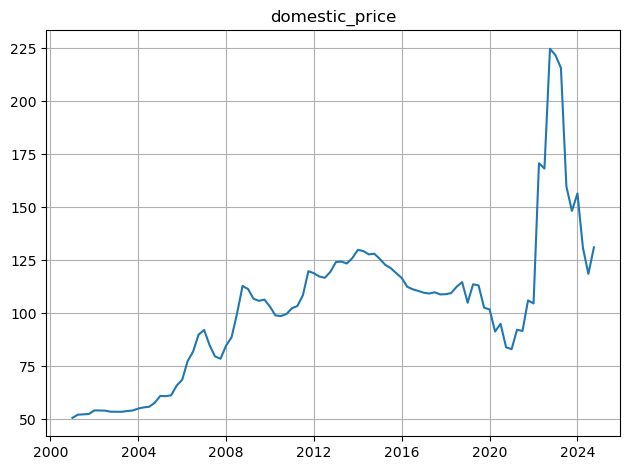

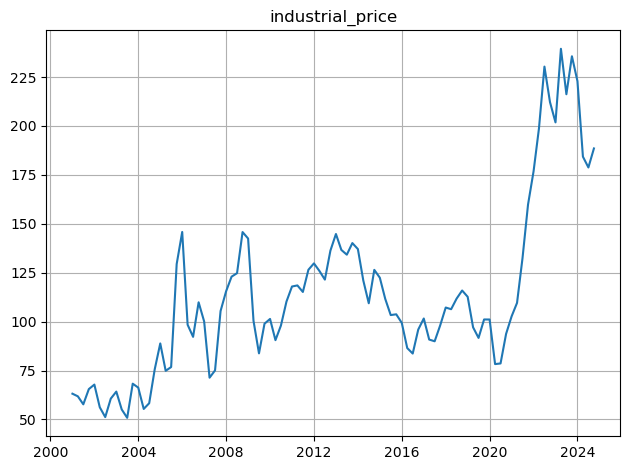

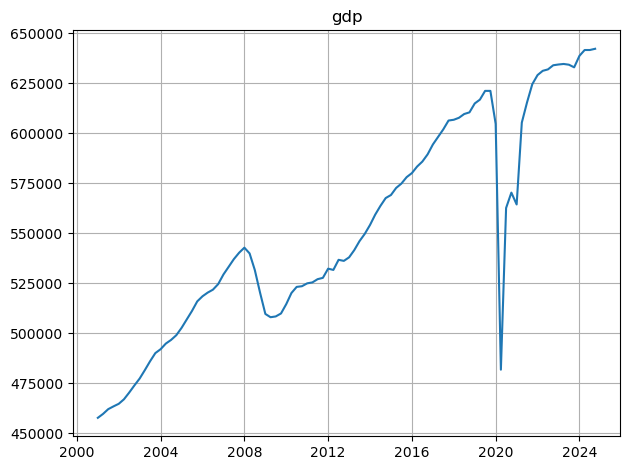

In [12]:
for i in df_indices.loc[:, df_indices.columns != 'date'].columns:
    plt.figure()
    plt.plot(df_indices['date'], df_indices[i])
    plt.title(i)
    plt.tight_layout()
    plt.grid(True)


#### Setting up Dataframe for Modelling

In [13]:
df = pd.merge(df_demand_final, df_weather, on='date')
df = pd.merge(df, df_indices, on='date')
df = df.rename(columns={'date':'ds'})
display(df.head())

,ds,domestic,industrials,elec,total,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price,gdp
0,2001-01-01,154586.0,137621.0,82019.0,374226.0,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926,457680
1,2001-04-01,69547.0,99687.0,78583.0,247817.0,178.485001,6.452538,8.241631,11.421111,3.693704,52.133440,61.809519,459620
2,2001-07-01,35197.0,76374.0,72592.0,184163.0,315.903293,5.462755,7.766157,15.850138,0.649218,52.296868,57.709785,462016
3,2001-10-01,120097.0,114234.0,79324.0,313655.0,386.582732,2.790973,9.458103,8.534337,7.166271,52.465025,65.499853,463404
4,2002-01-01,148988.0,125311.0,82446.0,356745.0,520.000982,2.735623,11.577786,6.979438,8.535148,54.150954,67.806783,464698


In [14]:
df1 = df.rename(columns={'total':'y'})
df1_train = df1[df1['ds'] < pd.Timestamp('2022-01-01')]
df1_test = df1[df1['ds'] >= pd.Timestamp('2022-01-01')]

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
model.add_seasonality('quarter', period=365/4, fourier_order=10, prior_scale=5)
model.fit(df1_train)


21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
df1_future = model.make_future_dataframe(periods=12, freq='QS')
df1_future.tail()

,ds
91,2023-10-01
92,2024-01-01
93,2024-04-01
94,2024-07-01
95,2024-10-01


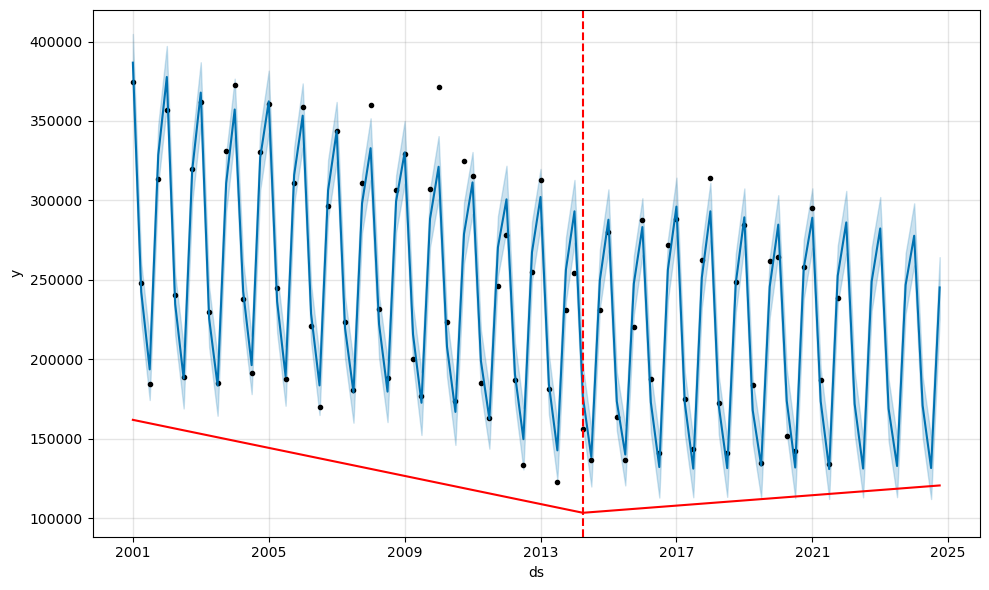

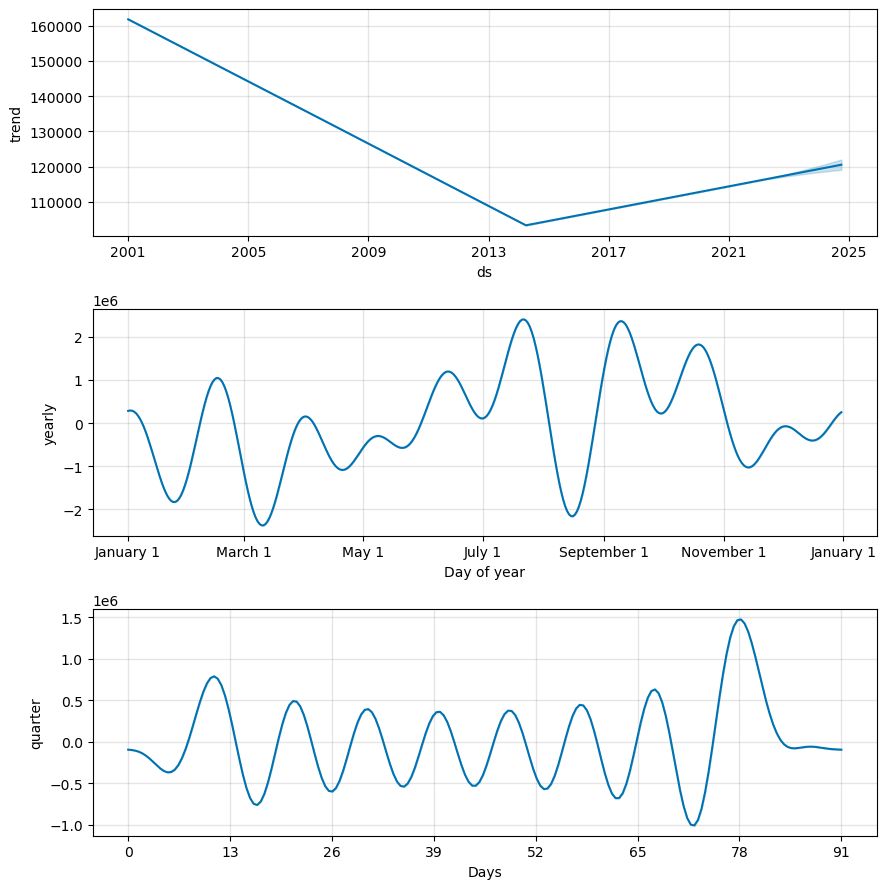

In [16]:
forecast = model.predict(df1_future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig = model.plot_components(forecast)

MAPE: 0.16
r2: 0.67


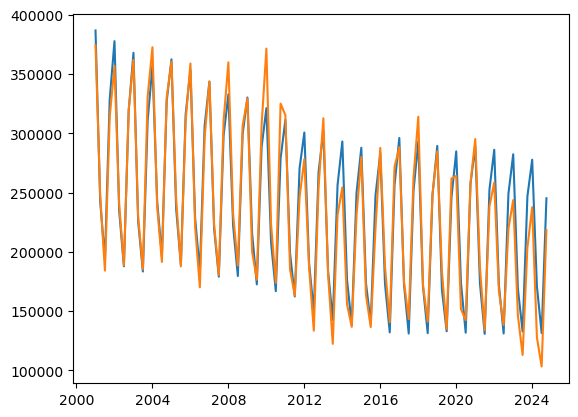

In [17]:
y_true = df1_test['y'].values
y_best = forecast['yhat'][-12:].values

mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)
r2 = r2_score(y_true, y_best)
print('r2: %.2f' % r2)

plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.plot(df1['ds'], df1['y'], label='training')
plt.legend=True

In [18]:
df2 = df.rename(columns={'total':'y'})
df2_train = df2[df2['ds'] < pd.Timestamp('2022-01-01')]
df2_test = df2[df2['ds'] >= pd.Timestamp('2022-01-01')]

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
model.add_seasonality('quarter', period=365/4, fourier_order=10, prior_scale=5)
#model.add_regressor('rainfall', mode='multiplicative')
#model.add_regressor('sunhours', mode='multiplicative')
#model.add_regressor('windspeed', mode='multiplicative')
model.add_regressor('temperature', mode='additive')
#model.add_regressor('heating_degree_days', mode='multiplicative')
model.add_regressor('industrial_price', mode='additive')
#model.add_regressor('domestic_price', mode='additive')
#model.add_regressor('gdp', mode='multiplicative')

model.fit(df2_train)


21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
df2_future = model.make_future_dataframe(periods=12, freq='QS')
df2_future = pd.merge(df2_future, df_weather, left_on='ds', right_on='date')
df2_future = df2_future.drop(['date'], axis=1)
df2_future = pd.merge(df2_future, df_indices, left_on='ds', right_on='date')
df2_future = df2_future.drop(['date'], axis=1)
df2_future

,ds,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price,gdp
0,2001-01-01,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926,457680
1,2001-04-01,178.485001,6.452538,8.241631,11.421111,3.693704,52.133440,61.809519,459620
2,2001-07-01,315.903293,5.462755,7.766157,15.850138,0.649218,52.296868,57.709785,462016
3,2001-10-01,386.582732,2.790973,9.458103,8.534337,7.166271,52.465025,65.499853,463404
4,2002-01-01,520.000982,2.735623,11.577786,6.979438,8.535148,54.150954,67.806783,464698
...,...,...,...,...,...,...,...,...,...
91,2023-10-01,458.254277,2.105616,9.068274,8.847127,6.711361,148.247093,235.610007,633011
92,2024-01-01,405.990154,2.433354,9.382006,6.818524,8.681476,156.467156,222.860382,638746
93,2024-04-01,254.473992,5.612069,7.989517,12.513213,3.176164,130.877542,184.296719,641670
94,2024-07-01,334.713264,5.312244,7.850166,15.614907,0.925958,118.535679,178.765668,641675


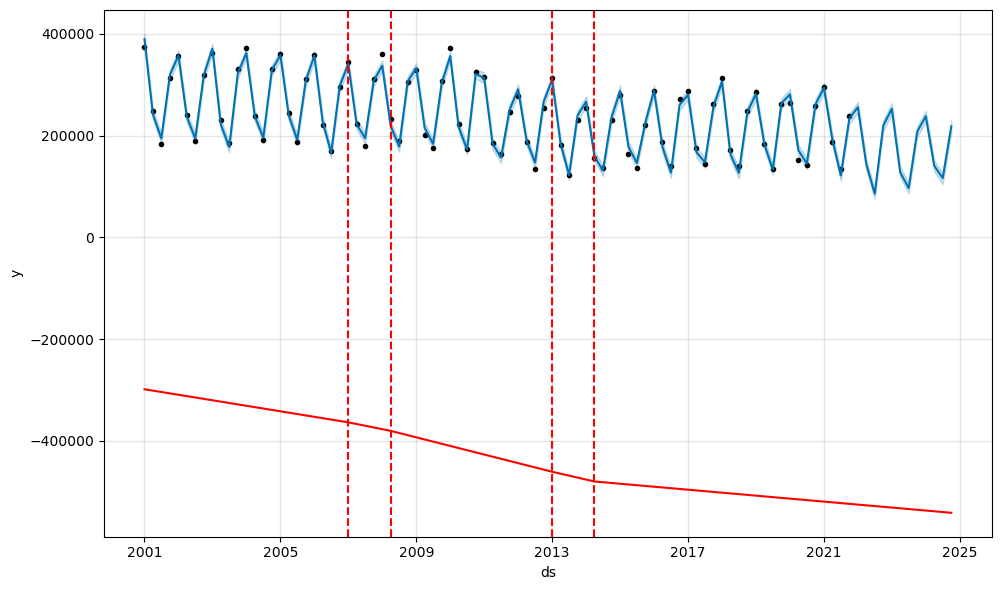

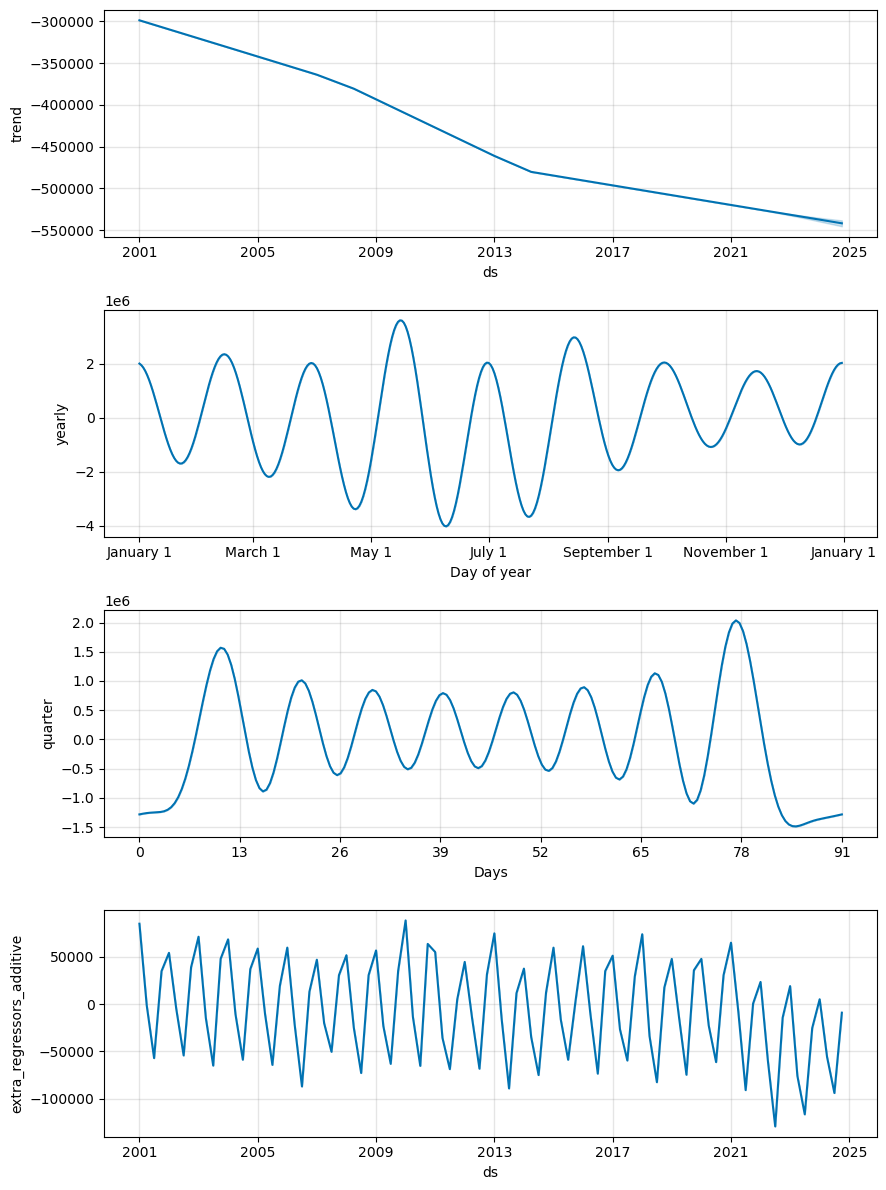

In [20]:
forecast = model.predict(df2_future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig = model.plot_components(forecast)

MAPE: 0.09
r2: 0.87


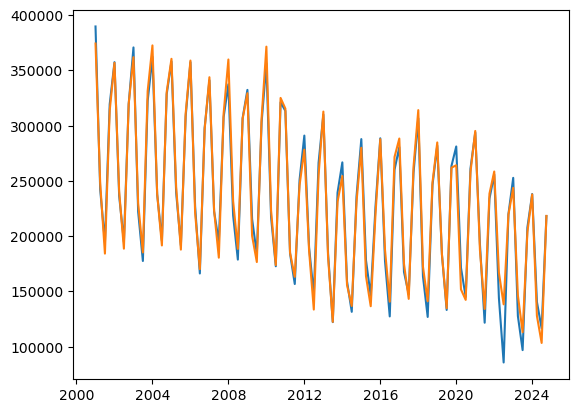

In [21]:
y_true = df2_test['y'].values
y_best = forecast['yhat'][-12:].values

mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)
r2 = r2_score(y_true, y_best)
print('r2: %.2f' % r2)

plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.plot(df2['ds'], df2['y'], label='training')
plt.legend=True

#### Modelling

In [30]:
df3 = df.rename(columns={'domestic':'y'})
df3['domestic_price_lag'] = df3['domestic_price'].shift(1)
df3['domestic_price_lag'] = df3['domestic_price_lag'].bfill()
df3['war'] = (df3['ds'] >= '2022-01-01').astype(int)
df3['price_war_interaction'] = df3['domestic_price_lag'] * df3['war']


scaler = StandardScaler()
df3[['domestic_price_lag_scaled','temperature_scaled','war_scaled']] = scaler.fit_transform(df3[['domestic_price_lag','temperature','war']])
df3['price_war_interaction_scaled'] = scaler.fit_transform(df3[['price_war_interaction']])


df3_train = df3[(df3['ds'] >= pd.Timestamp('2015-01-01'))
                & (df3['ds'] < pd.Timestamp('2023-01-01'))]
df3_test = df3[(df3['ds'] >= pd.Timestamp('2023-01-01')) 
               #& (df3['ds'] < pd.Timestamp('2020-01-01'))
               ]

model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01
    )
#model.add_seasonality('quarter', period=365/4, fourier_order=4, prior_scale=5)
#model.add_regressor('rainfall',  mode='multiplicative')
#model.add_regressor('sunhours', mode='multiplicative')
#model.add_regressor('windspeed',  mode='multiplicative')
model.add_regressor('temperature_scaled', mode='multiplicative')
#model.add_regressor('heating_degree_days',  mode='multiplicative')
#model.add_regressor('industrial_price', mode='multiplicative')
model.add_regressor('domestic_price_lag_scaled', mode='multiplicative')
#model.add_regressor('gdp',  mode='multiplicative')
model.add_regressor('war_scaled', mode='multiplicative')
model.add_regressor('price_war_interaction_scaled', mode='multiplicative')

model.fit(df3_train)

print(f'Training set: {len(df3_train)}')
print(f'Test set: {len(df3_test)}')

22:41:50 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing


Training set: 32
Test set: 8


In [31]:
df3_future = model.make_future_dataframe(periods=len(df3_test), freq='QS')
df3_future = pd.merge(df3_future, df_weather, left_on='ds', right_on='date')
df3_future = df3_future.drop(['date'], axis=1)
df3_future = pd.merge(df3_future, df_indices, left_on='ds', right_on='date')
df3_future = df3_future.drop(['date'], axis=1)
df3_future = pd.merge(df3_future, df3[['ds','domestic_price_lag_scaled','temperature_scaled','war_scaled','price_war_interaction_scaled']], on='ds')
df3_future.head()

,ds,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price,gdp,domestic_price_lag_scaled,temperature_scaled,war_scaled,price_war_interaction_scaled
0,2015-01-01,522.793241,3.275910,10.769266,5.160847,10.339153,125.578324,122.424371,569150,0.737104,-1.328763,-0.377964,-0.364735
1,2015-04-01,314.852054,6.808877,8.699706,11.313841,4.305678,122.815925,111.608746,572673,0.667569,0.221845,-0.377964,-0.364735
2,2015-07-01,259.452495,5.663107,7.773024,14.819255,1.265864,121.275497,103.334172,574836,0.590017,1.105239,-0.377964,-0.364735
3,2015-10-01,626.154373,1.822369,10.336437,9.965606,5.537371,118.874084,103.723245,578068,0.546770,-0.117922,-0.377964,-0.364735
4,2016-01-01,469.672602,2.872454,9.816948,5.632797,9.867203,116.599088,99.338332,580110,0.479352,-1.209827,-0.377964,-0.364735


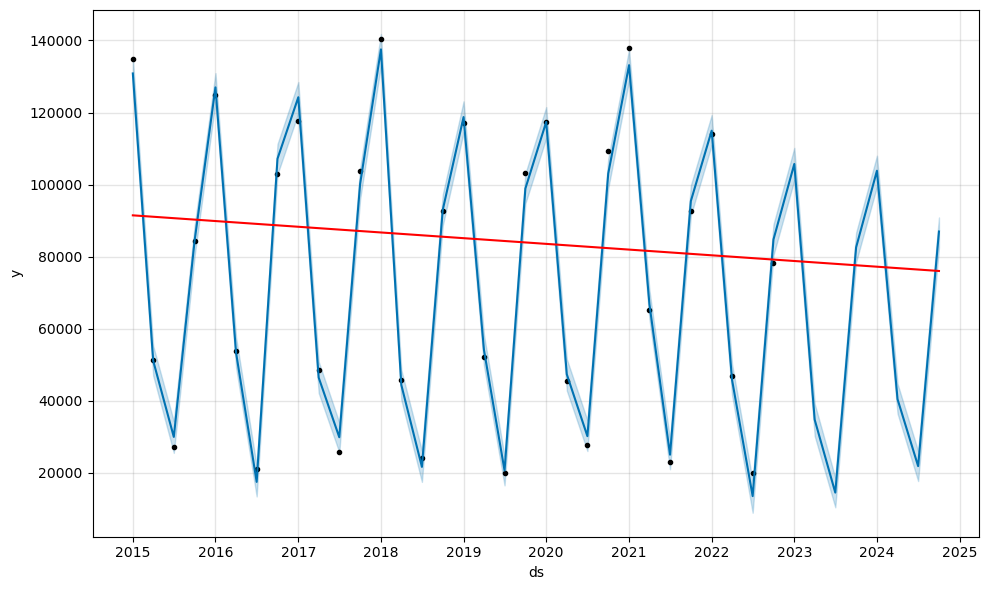

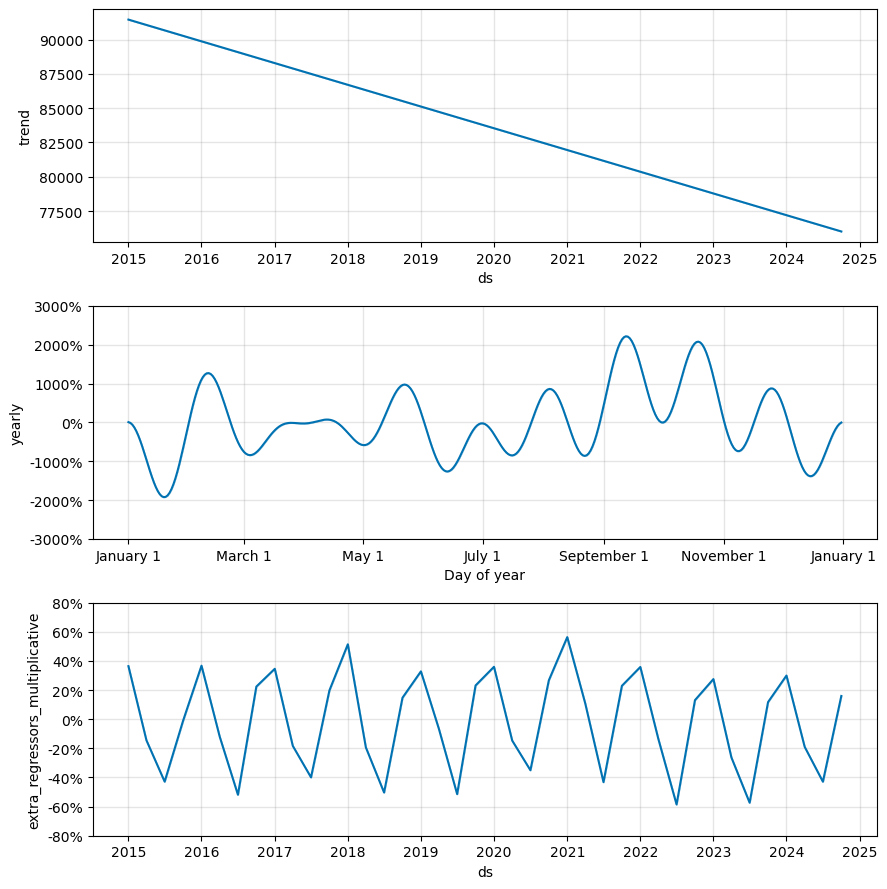

In [32]:
forecast = model.predict(df3_future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig = model.plot_components(forecast)

MSE: 2359.89
MAPE: 0.05


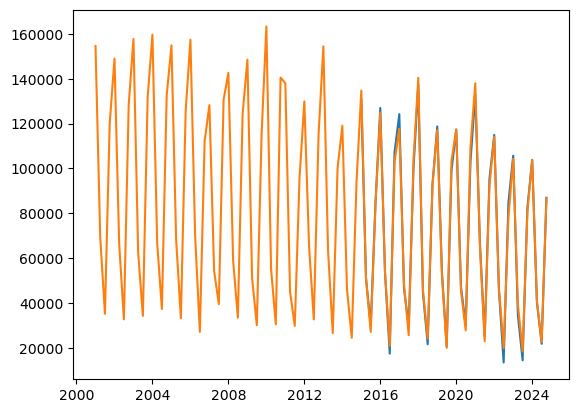

In [33]:
y_true = df3_test['y'].values
y_best = forecast['yhat'][-len(df3_test):].values


mse = np.sqrt(mean_squared_error(y_true, y_best))
print('MSE: %.2f' %mse)
mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)

plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.plot(df3['ds'], df3['y'], label='training')
plt.legend=True